In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import json
import time
import pickle
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import random
from IPython.display import Video

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

from keras.wrappers.scikit_learn import KerasClassifier
import keras_tuner as kt
import keras

import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_datasets as tfds
import torch
import glob
from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face

%matplotlib inline

In [3]:
data_def = pd.read_csv('data_definitiva.csv', sep = '|')
data_def = data_def.drop('Unnamed: 0', axis = 1)
data_def = data_def.values.tolist()

In [4]:
classes = list(set([x[1] for x in data_def]))

In [5]:
n_videos = len(data_def)
n_frames = 30
final_shape = (100, 100)

In [6]:
images = np.empty(shape = (n_videos, n_frames, final_shape[0], final_shape[1], 3), dtype=int)
labels = np.empty(shape = (n_videos), dtype = int)

In [7]:
torch_home = get_torch_home()

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


In [8]:
mtcnn = MTCNN(image_size =final_shape[0] ,margin=14, factor=0.5, post_process = False).eval()

resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

In [9]:
def process_image(images):
    n_images = len(images)
    f_shape = images[0].shape
    images_p = np.empty(shape = (n_images, f_shape[-2], f_shape[-1], f_shape[-3]), dtype = int)
    for i in range(n_images):
        images_p[i, :, :, :] = images[i][:,:,:].permute(1,2,0).int().numpy()
    return images_p    

In [10]:
class DetectionPipeline:

    def __init__(self, detector, n_frames=50):

        self.detector = detector
        self.n_frames = n_frames
        
    def __call__(self, filename):
 
   
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
        faces = []
        frames = []
        def_faces = []
        for j in range(v_len):
            success = v_cap.grab()
            success, frame = v_cap.retrieve()
            if not success:
                continue
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            frames.append(frame)
        
        idxs = [x for x in range(len(frames))]
        cond = True
        while cond:
            
            if len(idxs)>n_frames:
                slice_idxs =  random.sample(idxs, n_frames-len(def_faces))
                slice_idxs.sort()
                idxs = [x for x in idxs if x not in slice_idxs]
                sample = [frames[x] for x in slice_idxs]
                faces = self.detector(sample)
                temp_faces = [f for f in faces if f != None]
                def_faces.extend(temp_faces)
            else:
                def_faces.extend(frames)

            if len(def_faces)>=n_frames:
                cond = False
                def_faces = def_faces[:30]
        
        def_faces = process_image(def_faces)
        v_cap.release()
        
        return def_faces

In [11]:
detection_pipeline = DetectionPipeline(detector=mtcnn, n_frames = n_frames)

In [11]:
n_parts = 3
part = 1
intervals = np.linspace(0, n_videos, n_parts+1, dtype = int)

start, end = intervals[part-1], intervals[part]

In [13]:
for idx in tqdm(range(start, end)):
    video_path = data_def[idx][0]
    label = data_def[idx][1]
    images[idx, :, :, :, :] = detection_pipeline(video_path)
    labels[idx] = 0 if label == 'REAL' else 1

  0%|                                                                                          | 0/799 [00:00<?, ?it/s]C:\Users\DanielBaron\anaconda3\envs\gpu_env\lib\site-packages\facenet_pytorch\models\utils\detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
C:\Users\DanielBaron\anaconda3\envs\gpu_env\lib\site-packages\facenet_pytorch\models\mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
C:\Users\DanielBaron\anaconda3\envs\g

In [14]:
#Save the variables that contain the loaded images and their labels
f = open('images_part_{}.pckl'.format(part), 'wb')
pickle.dump(images[start:end,:,:,:,:], f)
f.close()

f = open('labels_{}.pckl'.format(part), 'wb')
pickle.dump(labels[start:end], f)
f.close()

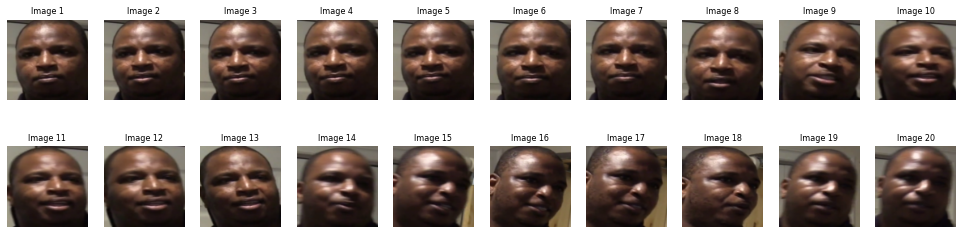

In [15]:
n = 210
W_grid = 10
L_grid = 2

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,4))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    axes[i].imshow(images[n,i,:,:,:], cmap ='gray')
    axes[i].set_title('Image {}'.format(i+1), fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [17]:
imgs = detection_pipeline('dataset/batch-00/aaqaifqrwn.mp4')

C:\Users\DanielBaron\anaconda3\envs\gpu_env\lib\site-packages\facenet_pytorch\models\utils\detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
C:\Users\DanielBaron\anaconda3\envs\gpu_env\lib\site-packages\facenet_pytorch\models\mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
C:\Users\DanielBaron\anaconda3\envs\gpu_env\lib\site-packages\facenet_pytorch\models\mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragge

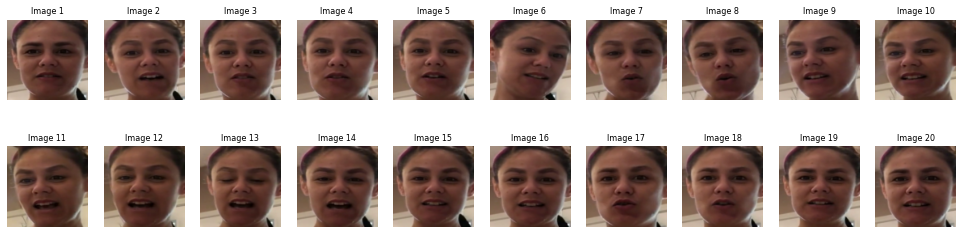

In [19]:
W_grid = 10
L_grid = 2

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,4))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    axes[i].imshow(imgs[i,:,:,:], cmap ='gray')
    axes[i].set_title('Image {}'.format(i+1), fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [20]:
v_cap = cv2.VideoCapture('dataset/batch-00/aaqaifqrwn.mp4')
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

faces = []
frames = []
def_faces = []
for j in range(v_len):
    success = v_cap.grab()
    success, frame = v_cap.retrieve()
    if not success:
        continue
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)
    frames.append(frame)
    if j == 50:
        break

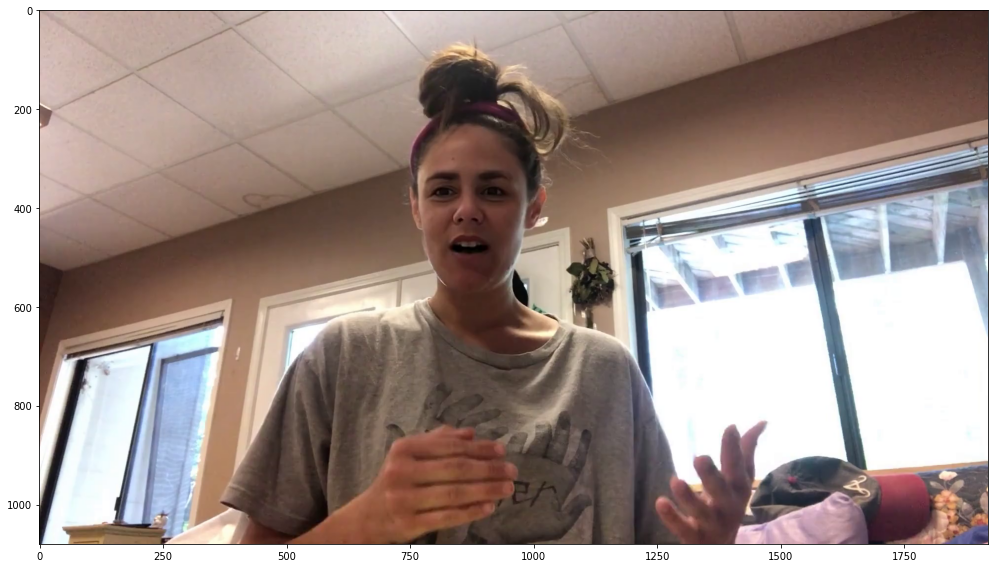

In [24]:
plt.figure(figsize=(17,17))
plt.imshow(frames[0])